# ERCOT Availability Model

**Optimized for: `final_master_hourly_data.csv`**

Uses pre-processed master file with:
- ✅ 12 ERCOT regional load columns (COAST, EAST, NORTH, SOUTH, etc.)
- ✅ 7 weighted weather features (temp_max, humidity, precipitation, etc.)
- ✅ Time features (hour, day, year)
- ✅ TOTAL load (target)

**Authors:** Troy McSimov, Trevor Kunz, Jeffrey Billo

**SMU Data Science Capstone Project**

## 1. Check GPU Availability

In [ ]:
# Check GPU
!nvidia-smi

import torch
print(f"\nPyTorch CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Sun Dec  7 17:39:10 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   63C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 2. Clone Repository and Install Dependencies

In [ ]:
# Clone repository
!git clone https://github.com/tskunz/ERCOT-Availability-Model
%cd ERCOT-Availability-Model

# Pull latest changes
!git pull origin main

print("✓ Repository cloned and updated")

# Install dependencies
!pip install -q -r requirements.txt
!pip install -q cupy-cuda11x

print("✓ Installation complete!")

fatal: destination path 'Capstone_Availability_Model' already exists and is not an empty directory.
/content/Capstone_Availability_Model
From https://github.com/tskunz/Capstone_Availability_Model
 * branch            main       -> FETCH_HEAD
Already up to date.
✓ Repository cloned and updated
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'
✓ Installation complete!


## 3. Mount Google Drive and Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Path to master data file
DATA_PATH = '/content/drive/MyDrive/final_master_hourly_data.csv'

print(f"Data path: {DATA_PATH}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data path: /content/drive/MyDrive/final_master_hourly_data.csv


## 4. Load and Explore Master Data

In [ ]:
import pandas as pd
import numpy as np

print("="*80)
print("LOADING MASTER DATA")
print("="*80)

# Load the master file
print(f"\nLoading: {DATA_PATH}")
df = pd.read_csv(DATA_PATH)

print(f"\n✓ Loaded successfully!")
print(f"  Shape: {df.shape}")
print(f"  Columns: {len(df.columns)}")
print(f"\nColumn list:")
print(df.columns.tolist())

# Data inventory
load_cols = ['COAST', 'EAST', 'FWEST', 'NORTH', 'NCENT', 'SOUTH', 'SCENT', 'WEST', 'FAR_WEST', 'NORTH_C', 'SOUTHERN', 'SOUTH_C', 'TOTAL']
weather_cols = [c for c in df.columns if 'weighted_' in c]
time_cols = [c for c in df.columns if c in ['hour', 'day', 'year', 'datetime_hour', 'Hour Ending']]

print(f"\n[DATA INVENTORY]")
print(f"  Regional load columns: {sum(1 for c in load_cols if c in df.columns)}/{len(load_cols)}")
print(f"  Weighted weather columns: {len(weather_cols)}")
if weather_cols:
    for col in weather_cols:
        print(f"    - {col}")
print(f"  Time features: {[c for c in df.columns if c in time_cols]}")

print(f"\nFirst few rows:")
print(df.head())

LOADING MASTER DATA

Loading: /content/drive/MyDrive/final_master_hourly_data.csv

✓ Loaded successfully!
  Shape: (96430, 29)
  Columns: 29

Column list:
['Hour Ending', 'COAST', 'EAST', 'FWEST', 'NORTH', 'NCENT', 'SOUTH', 'SCENT', 'WEST', 'FAR_WEST', 'NORTH_C', 'SOUTHERN', 'SOUTH_C', 'TOTAL', 'hour', 'day', 'year', 'datetime_hour', 'day_of_week', 'month', 'day_of_year', 'weighted_temp', 'weighted_humidity', 'weighted_precipitation', 'weighted_wind_speed', 'weighted_apparent_temp', 'weighted_dew_point', 'weighted_cloud_cover', 'weighted_wind_gusts']

[DATA INVENTORY]
  Regional load columns: 13/13
  Weighted weather columns: 8
    - weighted_temp
    - weighted_humidity
    - weighted_precipitation
    - weighted_wind_speed
    - weighted_apparent_temp
    - weighted_dew_point
    - weighted_cloud_cover
    - weighted_wind_gusts
  Time features: ['Hour Ending', 'hour', 'day', 'year', 'datetime_hour']

First few rows:
      Hour Ending        COAST         EAST        FWEST        NORT

## 5. Prepare Data for Modeling

In [ ]:
print("="*80)
print("DATA PREPARATION")
print("="*80)

# Ensure datetime column
if 'Hour Ending' in df.columns:
    df['datetime'] = pd.to_datetime(df['Hour Ending'])
elif 'datetime_hour' in df.columns:
    df['datetime'] = pd.to_datetime(df['datetime_hour'])
else:
    if all(c in df.columns for c in ['year', 'day', 'hour']):
        df['datetime'] = pd.to_datetime(
            df['year'].astype(str) +
            df['day'].astype(str).str.zfill(3) +
            df['hour'].astype(str).str.zfill(2),
            format='%Y%j%H'
        )

print(f"\nDate range: {df['datetime'].min()} to {df['datetime'].max()}")
print(f"Total hours: {len(df):,}")
print(f"Time span: {(df['datetime'].max() - df['datetime'].min()).days} days")

# Check for missing values
missing = df.isnull().sum()
if missing.sum() > 0:
    print(f"\nMissing values:")
    for col, count in missing[missing > 0].items():
        pct = (count / len(df)) * 100
        print(f"  {col}: {count} ({pct:.2f}%)")
else:
    print(f"\nNo missing values!")

# Prepare feature matrix
print(f"\n[PREPARING FEATURE MATRIX]")

# creating allow list to ensure correct fields are selected
feature_cols = [
    'hour',
    'day_of_week',
    'month',
    'day_of_year',
    'year',
    'weighted_temp',
    'weighted_humidity',
    'weighted_precipitation',
    'weighted_wind_speed',
    'weighted_apparent_temp',
    'weighted_dew_point',
    'weighted_cloud_cover',
    'weighted_wind_gusts'
]
# Setting target column
target_col = 'TOTAL'

# set x & y cols
X_full = df[feature_cols].copy()
y_full = df[target_col].copy()

# Handle any potential NaNs from the merge
# (e.g., if weather data was missing for a day)
if X_full.isnull().any().any():
    print("Warning: NaNs found in features. Filling with 0...")
    # Using 0 is a simple imputation. ffill() or interpolation
    # might be better, but 0 is safer than NaN for XGBoost.
    X_full = X_full.fillna(0)
    print("NaNs filled with 0")


print(f"  Features: {X_full.shape[1]}")
print(f"  Samples: {len(X_full):,}")
print(f"  Feature columns: {feature_cols[:10]}...")
print(f"\n  Data types:")
for col in feature_cols[:5]:
    print(f"    {col}: {X_full[col].dtype}")

# Ensure all numeric
X_full = X_full.apply(pd.to_numeric, errors='coerce')

print(f"\n✓ Feature matrix ready for TimeSeriesCV")

DATA PREPARATION


/tmp/ipython-input-2094592608.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['datetime'] = pd.to_datetime(df['Hour Ending'])
/tmp/ipython-input-2094592608.py:7: FutureWarning: Parsed string "11/05/2017 02:00 DST" included an un-recognized timezone "DST". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  df['datetime'] = pd.to_datetime(df['Hour Ending'])
/tmp/ipython-input-2094592608.py:7: FutureWarning: Parsed string "11/04/2018 02:00 DST" included an un-recognized timezone "DST". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  df['datetime'] = pd.to_datetime(df


Date range: 2014-01-01 01:00:00 to 2024-12-31 23:00:00
Total hours: 96,430
Time span: 4017 days

Missing values:
  FWEST: 8783 (9.11%)
  NCENT: 8783 (9.11%)
  SOUTH: 8783 (9.11%)
  SCENT: 8783 (9.11%)

[PREPARING FEATURE MATRIX]
  Features: 13
  Samples: 96,430
  Feature columns: ['hour', 'day_of_week', 'month', 'day_of_year', 'year', 'weighted_temp', 'weighted_humidity', 'weighted_precipitation', 'weighted_wind_speed', 'weighted_apparent_temp']...

  Data types:
    hour: int64
    day_of_week: int64
    month: int64
    day_of_year: int64
    year: int64

✓ Feature matrix ready for TimeSeriesCV


## 6. Diagnostic: TimeSeriesCV Strategy

TIME SERIES CROSS-VALIDATION STRATEGY

[DATA] Total samples: 96,430 (4017.9 days)
[CV] Using 5-Fold TimeSeriesCV with expanding window
[Fold size] ~16,071 samples (~669.6 days)

[FOLD STRUCTURE]

  Fold 1:
    Train: indices 0 → 16,071 (16,071 samples)
           2014-01-01 → 2015-11-01
    Test:  indices 16,071 → 32,142 (16,071 samples)
           2015-11-01 → 2017-09-01

  Fold 2:
    Train: indices 0 → 32,142 (32,142 samples)
           2014-01-01 → 2017-09-01
    Test:  indices 32,142 → 48,213 (16,071 samples)
           2017-09-01 → 2019-07-02

  Fold 3:
    Train: indices 0 → 48,213 (48,213 samples)
           2014-01-01 → 2019-07-02
    Test:  indices 48,213 → 64,284 (16,071 samples)
           2019-07-03 → 2021-05-02

  Fold 4:
    Train: indices 0 → 64,284 (64,284 samples)
           2014-01-01 → 2021-05-02
    Test:  indices 64,284 → 80,355 (16,071 samples)
           2021-05-02 → 2023-03-03

  Fold 5:
    Train: indices 0 → 80,355 (80,355 samples)
           2014-01-01 → 202

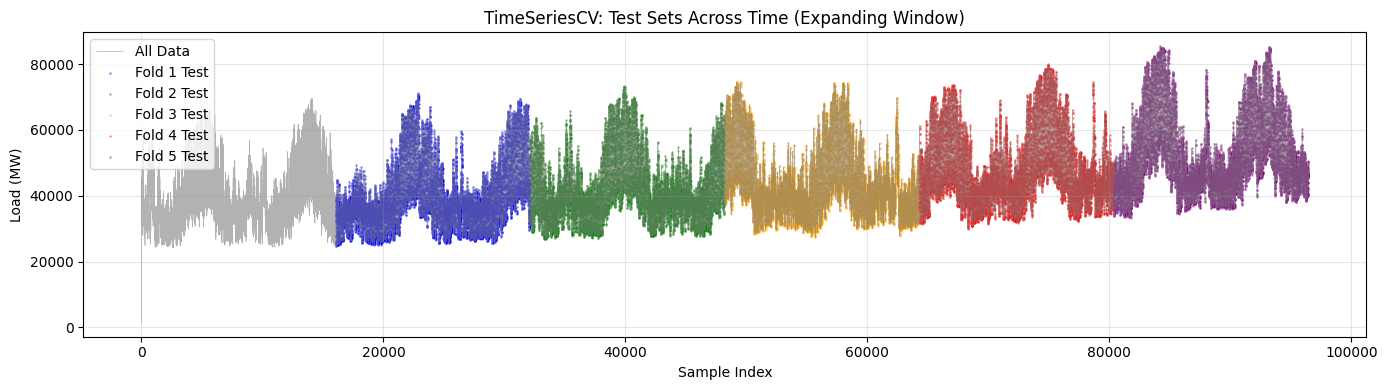


✓ TimeSeriesCV strategy ready


In [ ]:
import matplotlib.pyplot as plt

print("="*80)
print("TIME SERIES CROSS-VALIDATION STRATEGY")
print("="*80)

# Calculate fold boundaries
n_folds = 5
total_samples = len(X_full)
fold_size = total_samples // (n_folds + 1)

print(f"\n[DATA] Total samples: {total_samples:,} ({total_samples/24:.1f} days)")
print(f"[CV] Using {n_folds}-Fold TimeSeriesCV with expanding window")
print(f"[Fold size] ~{fold_size:,} samples (~{fold_size/24:.1f} days)")

print(f"\n[FOLD STRUCTURE]")
for fold in range(1, n_folds + 1):
    train_end = fold_size * fold
    test_start = train_end
    test_end = min(test_start + fold_size, total_samples)

    train_date = df['datetime'].iloc[train_end - 1]
    test_date = df['datetime'].iloc[test_end - 1]

    print(f"\n  Fold {fold}:")
    print(f"    Train: indices 0 → {train_end:,} ({train_end:,} samples)")
    print(f"           {df['datetime'].iloc[0].date()} → {train_date.date()}")
    print(f"    Test:  indices {test_start:,} → {test_end:,} ({test_end - test_start:,} samples)")
    print(f"           {df['datetime'].iloc[test_start].date()} → {test_date.date()}")

print(f"\n[KEY ADVANTAGES]")
print(f"  ✅ Respects temporal order (no future leakage)")
print(f"  ✅ Tests on multiple periods (catches distribution shifts)")
print(f"  ✅ Expanding window (more training data in later folds)")
print(f"  ✅ Robust metrics (averaged across {n_folds} folds)")

# Visualize
fig, ax = plt.subplots(figsize=(14, 4))

ax.plot(y_full.values, linewidth=0.5, alpha=0.6, color='gray', label='All Data')

colors = ['blue', 'green', 'orange', 'red', 'purple']
for fold in range(1, min(n_folds + 1, 6)):
    train_end = fold_size * fold
    test_start = train_end
    test_end = min(test_start + fold_size, total_samples)

    test_y = y_full.iloc[test_start:test_end].values
    test_x = np.arange(test_start, test_end)

    ax.scatter(test_x, test_y, s=1, alpha=0.3, color=colors[fold-1], label=f'Fold {fold} Test')

ax.set_xlabel('Sample Index')
ax.set_ylabel('Load (MW)')
ax.set_title('TimeSeriesCV: Test Sets Across Time (Expanding Window)')
ax.legend(loc='upper left')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n✓ TimeSeriesCV strategy ready")

## 7. Train STL-XGBoost with TimeSeriesCV

In [ ]:
from availability_model.forecasting import STLXGBoostForecaster
from availability_model.time_series_cv import TimeSeriesCV
import time

print("="*80)
print("STL-XGBOOST TRAINING WITH TIMESERIESCV")
print("="*80)

n_splits = 5
tscv = TimeSeriesCV(n_splits=n_splits)

print(f"\n[SETUP]")
print(f"  Model: STL-XGBoost with GPU acceleration")
print(f"  CV: {n_splits}-Fold TimeSeriesCV (expanding window)")
print(f"  Samples: {len(X_full):,}")
print(f"  Features: {X_full.shape[1]}")

# Store results
stl_fold_results = []
stl_fold_models = []
stl_fold_metrics = {'RMSE': [], 'MAE': [], 'MAPE': [], 'R2': []}

# Run CV
for fold_idx, (train_indices, test_indices) in enumerate(tscv.split(X_full), 1):
    print(f"\n{'='*80}")
    print(f"FOLD {fold_idx}/{n_splits} - STL-XGBOOST")
    print(f"{'='*80}")

    # Get fold data
    X_fold_train = X_full.iloc[train_indices]
    y_fold_train = y_full.iloc[train_indices]
    X_fold_test = X_full.iloc[test_indices]
    y_fold_test = y_full.iloc[test_indices]

    print(f"Train: {len(X_fold_train):,} samples | Test: {len(X_fold_test):,} samples")
    print(f"Train mean: {y_fold_train.mean():,.0f} MW | Test mean: {y_fold_test.mean():,.0f} MW")

    # Create validation split
    val_size = int(len(X_fold_train) * 0.1)
    X_fold_train_subset = X_fold_train.iloc[:-val_size]
    y_fold_train_subset = y_fold_train.iloc[:-val_size]
    X_fold_val = X_fold_train.iloc[-val_size:]
    y_fold_val = y_fold_train.iloc[-val_size:]

    print(f"Train subset: {len(X_fold_train_subset):,} | Val: {len(X_fold_val):,}")

    # Train
    print(f"\nTraining STL-XGBoost model...")
    start_time = time.time()

    forecaster = STLXGBoostForecaster(use_gpu=True)
    forecaster.fit(
        X_fold_train_subset,
        y_fold_train_subset,
        X_val=X_fold_val,
        y_val=y_fold_val,
        plot_decomposition=(fold_idx == 1)
    )

    training_time = time.time() - start_time

    # Evaluate
    fold_metrics_dict = forecaster.evaluate(X_fold_test, y_fold_test, plot=(fold_idx == 1))

    print(f"\n✓ Fold {fold_idx} complete ({training_time:.2f}s)")
    print(f"  RMSE: {fold_metrics_dict['RMSE']:.2f} MW")
    print(f"  MAE:  {fold_metrics_dict['MAE']:.2f} MW")
    print(f"  MAPE: {fold_metrics_dict['MAPE']:.2f}%")
    print(f"  R²:   {fold_metrics_dict['R2']:.4f}")

    # Store results
    stl_fold_results.append({
        'fold': fold_idx,
        'train_size': len(X_fold_train_subset),
        'test_size': len(X_fold_test),
        'train_mean': y_fold_train_subset.mean(),
        'test_mean': y_fold_test.mean(),
        'rmse': fold_metrics_dict['RMSE'],
        'mae': fold_metrics_dict['MAE'],
        'mape': fold_metrics_dict['MAPE'],
        'r2': fold_metrics_dict['R2']
    })

    stl_fold_models.append(forecaster)
    for metric in ['RMSE', 'MAE', 'MAPE', 'R2']:
        stl_fold_metrics[metric].append(fold_metrics_dict[metric])

# Summary
print(f"\n{'='*80}")
print(f"STL-XGBOOST RESULTS")
print(f"{'='*80}")

stl_results_df = pd.DataFrame(stl_fold_results)
print(f"\n{stl_results_df.to_string(index=False)}")

print(f"\n[AVERAGE METRICS]")
for metric in ['RMSE', 'MAE', 'MAPE', 'R2']:
    mean_val = np.mean(stl_fold_metrics[metric])
    std_val = np.std(stl_fold_metrics[metric])
    print(f"  {metric}: {mean_val:.2f} ± {std_val:.2f}")

best_fold_idx = np.argmin(stl_fold_metrics['RMSE'])
best_forecaster = stl_fold_models[best_fold_idx]
print(f"\n[BEST FOLD] Fold {best_fold_idx + 1} selected")

STL-XGBOOST TRAINING WITH TIMESERIESCV

[SETUP]
  Model: STL-XGBoost with GPU acceleration
  CV: 5-Fold TimeSeriesCV (expanding window)
  Samples: 96,430
  Features: 13

FOLD 1/5 - STL-XGBOOST
Train: 16,071 samples | Test: 16,071 samples
Train mean: 39,717 MW | Test mean: 39,945 MW
Train subset: 14,464 | Val: 1,607

Training STL-XGBoost model...
[0]	train-rmse:2877.17928	val-rmse:10404.44357
[50]	train-rmse:1902.43349	val-rmse:10079.12529
[100]	train-rmse:1625.57093	val-rmse:9981.51351
[142]	train-rmse:1490.84878	val-rmse:9961.89098

✓ Fold 1 complete (15.51s)
  RMSE: 11288.75 MW
  MAE:  9792.78 MW
  MAPE: 27.16%
  R²:   -0.4309

FOLD 2/5 - STL-XGBOOST
Train: 32,142 samples | Test: 16,071 samples
Train mean: 39,831 MW | Test mean: 41,831 MW
Train subset: 28,928 | Val: 3,214

Training STL-XGBoost model...
[0]	train-rmse:2655.55402	val-rmse:11292.18529
[50]	train-rmse:1821.16694	val-rmse:11197.14293
[100]	train-rmse:1619.68679	val-rmse:11087.61248
[150]	train-rmse:1506.42224	val-rmse:110

## 8. Train Hybrid Model with TimeSeriesCV

In [ ]:
from availability_model.hybrid_forecasting import HybridTrendSeasonalityForecaster

print("="*80)
print("HYBRID TREND+SEASONALITY TRAINING WITH TIMESERIESCV")
print("="*80)

print(f"\nHybrid Architecture:")
print(f"  1. Linear Regression on time index → Trend")
print(f"  2. Detrend target: y_detrended = y - trend")
print(f"  3. XGBoost on detrended residuals → Seasonality")
print(f"  4. Final prediction: Trend + Seasonality")

# Store results
hybrid_fold_results = []
hybrid_fold_models = []
hybrid_fold_metrics = {'RMSE': [], 'MAE': [], 'MAPE': [], 'R2': []}

# Run CV
for fold_idx, (train_indices, test_indices) in enumerate(tscv.split(X_full), 1):
    print(f"\n{'='*80}")
    print(f"FOLD {fold_idx}/{n_splits} - HYBRID MODEL")
    print(f"{'='*80}")

    # Get fold data
    X_fold_train = X_full.iloc[train_indices]
    y_fold_train = y_full.iloc[train_indices]
    X_fold_test = X_full.iloc[test_indices]
    y_fold_test = y_full.iloc[test_indices]

    print(f"Train: {len(X_fold_train):,} samples | Test: {len(X_fold_test):,} samples")

    # Create validation split
    val_size = int(len(X_fold_train) * 0.1)
    X_fold_train_subset = X_fold_train.iloc[:-val_size]
    y_fold_train_subset = y_fold_train.iloc[:-val_size]
    X_fold_val = X_fold_train.iloc[-val_size:]
    y_fold_val = y_fold_train.iloc[-val_size:]

    # Calculate validation start index in ORIGINAL temporal position
    # Validation is taken from end of X_fold_train, so its start index is:
    # train_indices[0] + (len(X_fold_train) - len(X_fold_val))
    val_start_idx = train_indices[0] + (len(X_fold_train) - len(X_fold_val))

    # Train
    print(f"\nTraining Hybrid model...")
    print(f"Validation temporal indices: [{val_start_idx}:{val_start_idx + len(X_fold_val)}]")
    start_time = time.time()

    hybrid_forecaster = HybridTrendSeasonalityForecaster(use_gpu=True)
    hybrid_forecaster.fit(
        X_fold_train_subset,
        y_fold_train_subset,
        X_val=X_fold_val,
        y_val=y_fold_val,
        plot_decomposition=(fold_idx == 1),
        val_start_idx=val_start_idx
    )

    training_time = time.time() - start_time

    # Evaluate
    fold_metrics_dict = hybrid_forecaster.evaluate(
        X_fold_test,
        y_fold_test,
        plot=(fold_idx == 1),
        start_idx=len(X_fold_train)
    )

    print(f"\n✓ Fold {fold_idx} complete ({training_time:.2f}s)")
    print(f"  RMSE: {fold_metrics_dict['RMSE']:.2f} MW")
    print(f"  MAE:  {fold_metrics_dict['MAE']:.2f} MW")
    print(f"  MAPE: {fold_metrics_dict['MAPE']:.2f}%")
    print(f"  R²:   {fold_metrics_dict['R2']:.4f}")

    # Store results
    hybrid_fold_results.append({
        'fold': fold_idx,
        'train_size': len(X_fold_train_subset),
        'test_size': len(X_fold_test),
        'rmse': fold_metrics_dict['RMSE'],
        'mae': fold_metrics_dict['MAE'],
        'mape': fold_metrics_dict['MAPE'],
        'r2': fold_metrics_dict['R2']
    })

    hybrid_fold_models.append(hybrid_forecaster)
    for metric in ['RMSE', 'MAE', 'MAPE', 'R2']:
        hybrid_fold_metrics[metric].append(fold_metrics_dict[metric])

# Summary
print(f"\n{'='*80}")
print(f"HYBRID MODEL RESULTS")
print(f"{'='*80}")

hybrid_results_df = pd.DataFrame(hybrid_fold_results)
print(f"\n{hybrid_results_df.to_string(index=False)}")

print(f"\n[AVERAGE METRICS]")
for metric in ['RMSE', 'MAE', 'MAPE', 'R2']:
    mean_val = np.mean(hybrid_fold_metrics[metric])
    std_val = np.std(hybrid_fold_metrics[metric])
    print(f"  {metric}: {mean_val:.2f} ± {std_val:.2f}")

best_hybrid_idx = np.argmin(hybrid_fold_metrics['RMSE'])
best_hybrid_forecaster = hybrid_fold_models[best_hybrid_idx]
print(f"\n[BEST FOLD] Fold {best_hybrid_idx + 1} selected")

HYBRID TREND+SEASONALITY TRAINING WITH TIMESERIESCV

Hybrid Architecture:
  1. Linear Regression on time index → Trend
  2. Detrend target: y_detrended = y - trend
  3. XGBoost on detrended residuals → Seasonality
  4. Final prediction: Trend + Seasonality

FOLD 1/5 - HYBRID MODEL
Train: 16,071 samples | Test: 16,071 samples

Training Hybrid model...
Validation temporal indices: [14464:16071]
[0]	train-rmse:8563.11391	val-rmse:8968.37869
[50]	train-rmse:2090.42157	val-rmse:3143.58690
[100]	train-rmse:1381.61473	val-rmse:2407.82529
[150]	train-rmse:1211.89981	val-rmse:2194.87413
[191]	train-rmse:1123.93643	val-rmse:2088.40806

✓ Fold 1 complete (2.02s)
  RMSE: 4808.15 MW
  MAE:  4280.56 MW
  MAPE: 11.58%
  R²:   0.7404

FOLD 2/5 - HYBRID MODEL
Train: 32,142 samples | Test: 16,071 samples

Training Hybrid model...
Validation temporal indices: [28928:32142]
[0]	train-rmse:8531.12900	val-rmse:11769.18640
[50]	train-rmse:2133.41823	val-rmse:3825.60768
[100]	train-rmse:1480.11425	val-rmse:31

## 9. Compare Both Models

MODEL COMPARISON: STL-XGBOOST vs HYBRID

      Model    RMSE_Mean    RMSE_Std    MAE_Mean   R2_Mean
STL-XGBoost 10592.788278 1711.210001 8222.294425 -0.157042
     Hybrid  3265.803826  940.683283 2675.990794  0.880282

[COMPARISON]
  RMSE Difference: +7326.98 MW (+69.17%)
  ✅ HYBRID WINS by 69.2%


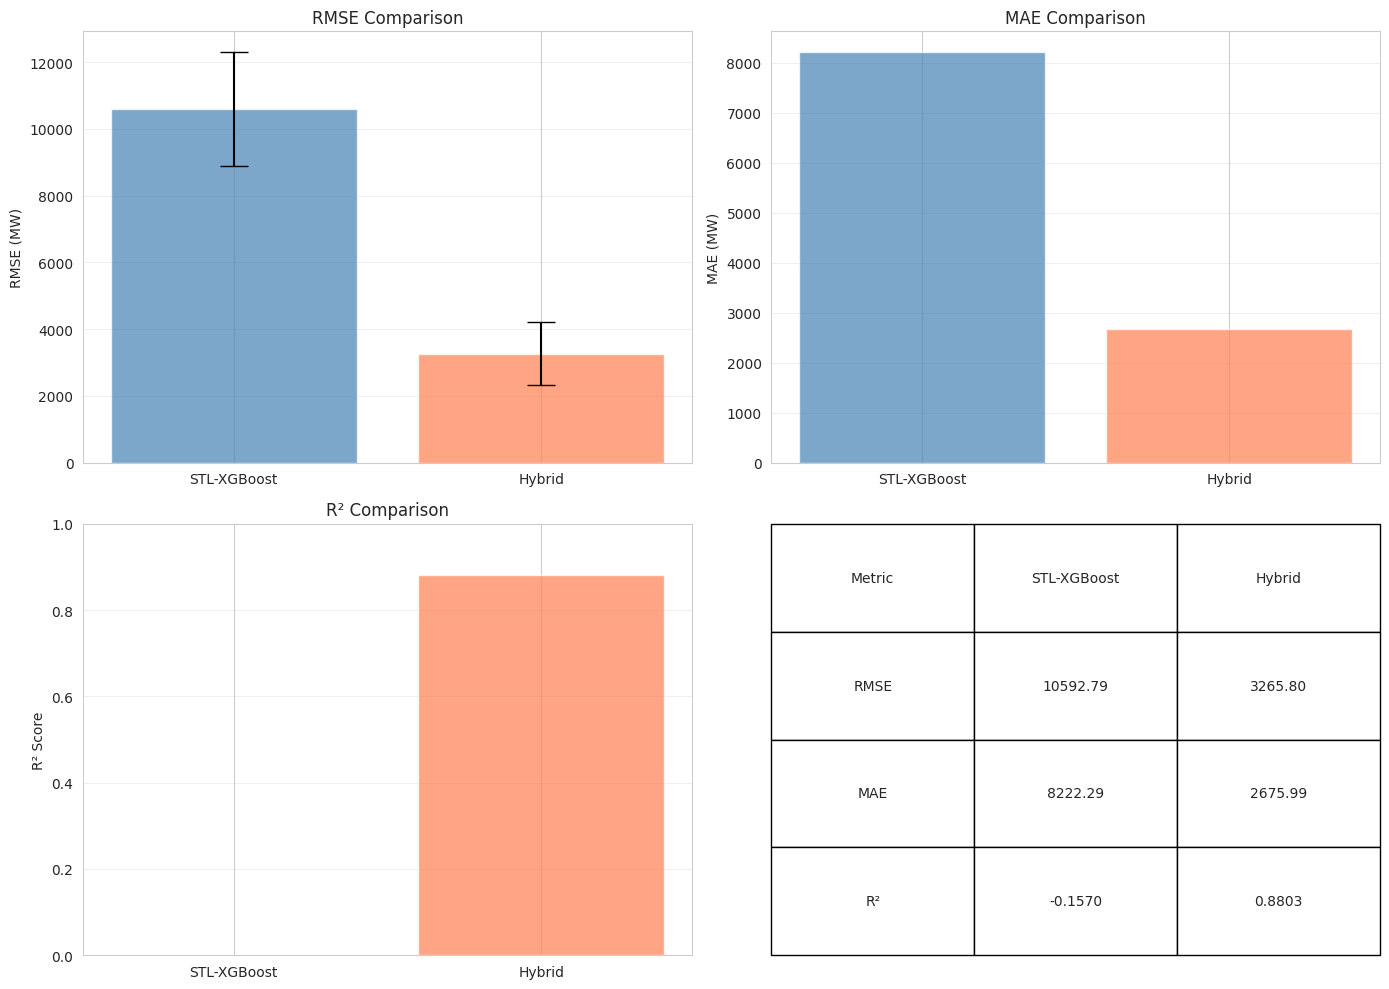


✓ Comparison complete


In [ ]:
print("="*80)
print("MODEL COMPARISON: STL-XGBOOST vs HYBRID")
print("="*80)

stl_metrics_summary = {
    'Model': 'STL-XGBoost',
    'RMSE_Mean': np.mean(stl_fold_metrics['RMSE']),
    'RMSE_Std': np.std(stl_fold_metrics['RMSE']),
    'MAE_Mean': np.mean(stl_fold_metrics['MAE']),
    'R2_Mean': np.mean(stl_fold_metrics['R2']),
}

hybrid_metrics_summary = {
    'Model': 'Hybrid',
    'RMSE_Mean': np.mean(hybrid_fold_metrics['RMSE']),
    'RMSE_Std': np.std(hybrid_fold_metrics['RMSE']),
    'MAE_Mean': np.mean(hybrid_fold_metrics['MAE']),
    'R2_Mean': np.mean(hybrid_fold_metrics['R2']),
}

comparison_df = pd.DataFrame([stl_metrics_summary, hybrid_metrics_summary])
print(f"\n{comparison_df[['Model', 'RMSE_Mean', 'RMSE_Std', 'MAE_Mean', 'R2_Mean']].to_string(index=False)}")

# Calculate improvement
rmse_improvement = stl_metrics_summary['RMSE_Mean'] - hybrid_metrics_summary['RMSE_Mean']
rmse_improvement_pct = (rmse_improvement / stl_metrics_summary['RMSE_Mean']) * 100

print(f"\n[COMPARISON]")
print(f"  RMSE Difference: {rmse_improvement:+.2f} MW ({rmse_improvement_pct:+.2f}%)")

if rmse_improvement > 0:
    print(f"  ✅ HYBRID WINS by {abs(rmse_improvement_pct):.1f}%")
else:
    print(f"  ✅ STL-XGBOOST WINS by {abs(rmse_improvement_pct):.1f}%")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# RMSE
ax = axes[0, 0]
models = ['STL-XGBoost', 'Hybrid']
rmse_means = [stl_metrics_summary['RMSE_Mean'], hybrid_metrics_summary['RMSE_Mean']]
rmse_stds = [stl_metrics_summary['RMSE_Std'], hybrid_metrics_summary['RMSE_Std']]
ax.bar(models, rmse_means, yerr=rmse_stds, capsize=10, color=['steelblue', 'coral'], alpha=0.7)
ax.set_ylabel('RMSE (MW)')
ax.set_title('RMSE Comparison')
ax.grid(axis='y', alpha=0.3)

# MAE
ax = axes[0, 1]
mae_means = [stl_metrics_summary['MAE_Mean'], hybrid_metrics_summary['MAE_Mean']]
ax.bar(models, mae_means, color=['steelblue', 'coral'], alpha=0.7)
ax.set_ylabel('MAE (MW)')
ax.set_title('MAE Comparison')
ax.grid(axis='y', alpha=0.3)

# R2
ax = axes[1, 0]
r2_means = [stl_metrics_summary['R2_Mean'], hybrid_metrics_summary['R2_Mean']]
ax.bar(models, r2_means, color=['steelblue', 'coral'], alpha=0.7)
ax.set_ylabel('R² Score')
ax.set_title('R² Comparison')
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)

# Metrics table
ax = axes[1, 1]
ax.axis('off')
table_data = [
    ['Metric', 'STL-XGBoost', 'Hybrid'],
    ['RMSE', f"{stl_metrics_summary['RMSE_Mean']:.2f}", f"{hybrid_metrics_summary['RMSE_Mean']:.2f}"],
    ['MAE', f"{stl_metrics_summary['MAE_Mean']:.2f}", f"{hybrid_metrics_summary['MAE_Mean']:.2f}"],
    ['R²', f"{stl_metrics_summary['R2_Mean']:.4f}", f"{hybrid_metrics_summary['R2_Mean']:.4f}"]
]
ax.table(cellText=table_data, cellLoc='center', loc='center', bbox=[0, 0, 1, 1])

plt.tight_layout()
plt.show()

print(f"\n✓ Comparison complete")

## 10. Forecast vs Actual: Side-by-Side Comparison

SIDE-BY-SIDE FORECAST COMPARISON

Generating predictions from both models on the last fold test set...

Using last fold test set: 16071 hours (most recent data)

Generating STL-XGBoost forecasts...
  RMSE: 16740.30 MW
  MAE:  13048.15 MW
  MAPE: 22.28%
  R²:   -1.1993

Generating Hybrid forecasts...
  RMSE: 3605.01 MW
  MAE:  3000.77 MW
  MAPE: 5.55%
  R²:   0.8980

[Comparison]
  RMSE Difference: +13135.29 MW (+78.47%)

✓ Saved comparison visualization


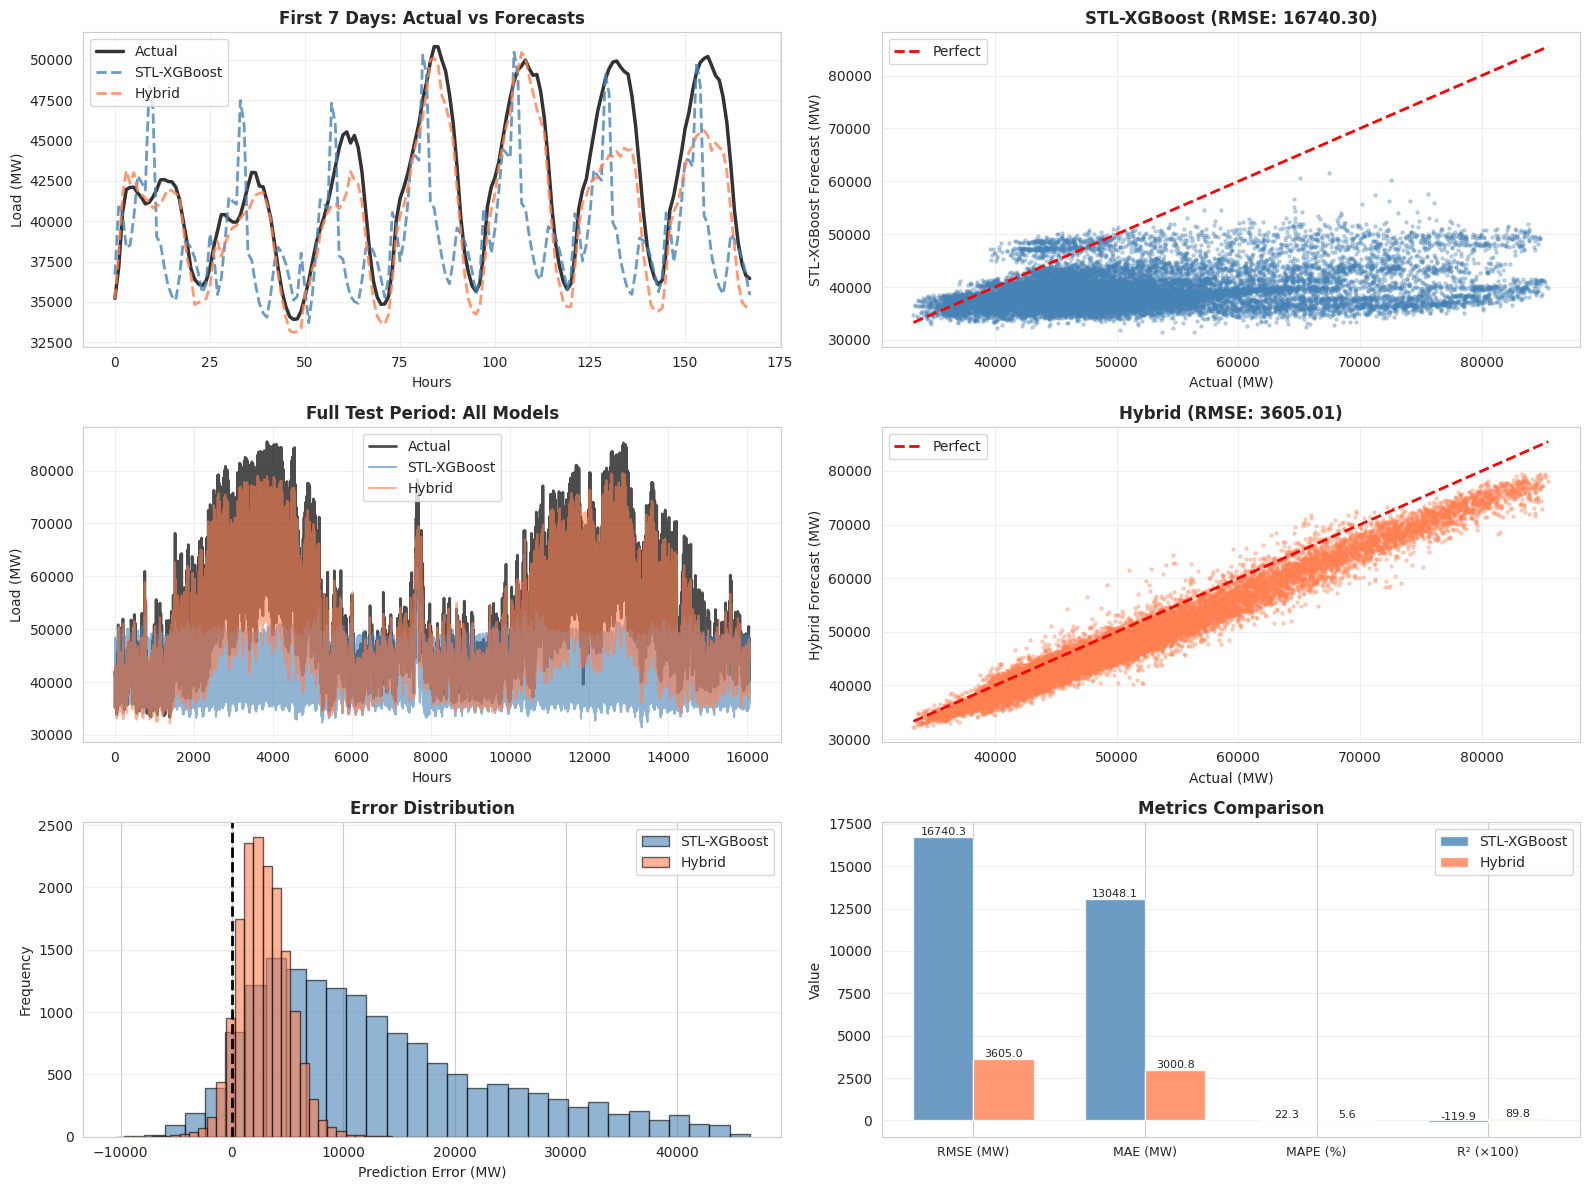


DETAILED FORECAST METRICS COMPARISON

   Metric STL-XGBoost  Hybrid Winner
RMSE (MW)    16740.30 3605.01 Hybrid
 MAE (MW)    13048.15 3000.77 Hybrid
 MAPE (%)       22.28    5.55 Hybrid
 R² Score     -1.1993  0.8980 Hybrid

✅ FORECAST COMPARISON COMPLETE


In [ ]:
print("="*80)
print("SIDE-BY-SIDE FORECAST COMPARISON")
print("="*80)

print("\nGenerating predictions from both models on the last fold test set...")

# Get the last fold test data (most recent data)
last_fold_idx = n_splits - 1
train_indices_last, test_indices_last = list(tscv.split(X_full))[-1]

X_test_last = X_full.iloc[test_indices_last]
y_test_last = y_full.iloc[test_indices_last]

print(f"\nUsing last fold test set: {len(y_test_last)} hours (most recent data)")

# STL-XGBoost predictions
print(f"\nGenerating STL-XGBoost forecasts...")
stl_pred = best_forecaster.predict(X_test_last)
stl_metrics_dict = best_forecaster.evaluate(X_test_last, y_test_last, plot=False)

print(f"  RMSE: {stl_metrics_dict['RMSE']:.2f} MW")
print(f"  MAE:  {stl_metrics_dict['MAE']:.2f} MW")
print(f"  MAPE: {stl_metrics_dict['MAPE']:.2f}%")
print(f"  R²:   {stl_metrics_dict['R2']:.4f}")

# Hybrid predictions
print(f"\nGenerating Hybrid forecasts...")
hybrid_pred = best_hybrid_forecaster.predict(X_test_last, start_idx=len(X_full) - len(X_test_last))
hybrid_metrics_dict = best_hybrid_forecaster.evaluate(X_test_last, y_test_last, plot=False,
                                                      start_idx=len(X_full) - len(X_test_last))

print(f"  RMSE: {hybrid_metrics_dict['RMSE']:.2f} MW")
print(f"  MAE:  {hybrid_metrics_dict['MAE']:.2f} MW")
print(f"  MAPE: {hybrid_metrics_dict['MAPE']:.2f}%")
print(f"  R²:   {hybrid_metrics_dict['R2']:.4f}")

# Calculate difference
diff_rmse = stl_metrics_dict['RMSE'] - hybrid_metrics_dict['RMSE']
diff_pct = (diff_rmse / stl_metrics_dict['RMSE']) * 100

print(f"\n[Comparison]")
print(f"  RMSE Difference: {diff_rmse:+.2f} MW ({diff_pct:+.2f}%)")

# Create comprehensive visualization
fig, axes = plt.subplots(3, 2, figsize=(16, 12))

# ===== ROW 1: Time Series Comparison =====

# Plot 1: First 7 days
ax = axes[0, 0]
n_hours_plot = min(7 * 24, len(y_test_last))
hours = np.arange(n_hours_plot)

ax.plot(hours, y_test_last.values[:n_hours_plot], 'k-', linewidth=2.5, label='Actual', alpha=0.8)
ax.plot(hours, stl_pred[:n_hours_plot], '--', linewidth=2, label='STL-XGBoost', color='steelblue', alpha=0.8)
ax.plot(hours, hybrid_pred[:n_hours_plot], '--', linewidth=2, label='Hybrid', color='coral', alpha=0.8)
ax.set_xlabel('Hours')
ax.set_ylabel('Load (MW)')
ax.set_title('First 7 Days: Actual vs Forecasts', fontsize=12, fontweight='bold')
ax.legend(loc='best')
ax.grid(alpha=0.3)

# Plot 2: Scatter STL-XGBoost
ax = axes[0, 1]
ax.scatter(y_test_last, stl_pred, alpha=0.3, s=5, color='steelblue')
ax.plot([y_test_last.min(), y_test_last.max()],
        [y_test_last.min(), y_test_last.max()],
        'r--', linewidth=2, label='Perfect')
ax.set_xlabel('Actual (MW)')
ax.set_ylabel('STL-XGBoost Forecast (MW)')
ax.set_title(f'STL-XGBoost (RMSE: {stl_metrics_dict["RMSE"]:.2f})', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# ===== ROW 2: Full Period Comparison =====

# Plot 3: Full time series with both models
ax = axes[1, 0]
ax.plot(np.arange(len(y_test_last)), y_test_last.values, 'k-', linewidth=2, label='Actual', alpha=0.7)
ax.plot(np.arange(len(y_test_last)), stl_pred, '-', linewidth=1.5, label='STL-XGBoost',
        color='steelblue', alpha=0.6)
ax.plot(np.arange(len(y_test_last)), hybrid_pred, '-', linewidth=1.5, label='Hybrid',
        color='coral', alpha=0.6)
ax.set_xlabel('Hours')
ax.set_ylabel('Load (MW)')
ax.set_title('Full Test Period: All Models', fontsize=12, fontweight='bold')
ax.legend(loc='best')
ax.grid(alpha=0.3)

# Plot 4: Scatter Hybrid
ax = axes[1, 1]
ax.scatter(y_test_last, hybrid_pred, alpha=0.3, s=5, color='coral')
ax.plot([y_test_last.min(), y_test_last.max()],
        [y_test_last.min(), y_test_last.max()],
        'r--', linewidth=2, label='Perfect')
ax.set_xlabel('Actual (MW)')
ax.set_ylabel('Hybrid Forecast (MW)')
ax.set_title(f'Hybrid (RMSE: {hybrid_metrics_dict["RMSE"]:.2f})', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# ===== ROW 3: Error Analysis =====

# Plot 5: Error distribution
ax = axes[2, 0]
stl_errors = y_test_last.values - stl_pred
hybrid_errors = y_test_last.values - hybrid_pred

ax.hist(stl_errors, bins=30, alpha=0.6, label='STL-XGBoost', color='steelblue', edgecolor='black')
ax.hist(hybrid_errors, bins=30, alpha=0.6, label='Hybrid', color='coral', edgecolor='black')
ax.axvline(0, color='black', linestyle='--', linewidth=2)
ax.set_xlabel('Prediction Error (MW)')
ax.set_ylabel('Frequency')
ax.set_title('Error Distribution', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3, axis='y')

# Plot 6: Metrics comparison
ax = axes[2, 1]
metrics = ['RMSE (MW)', 'MAE (MW)', 'MAPE (%)', 'R² (×100)']
stl_vals = [stl_metrics_dict['RMSE'], stl_metrics_dict['MAE'],
            stl_metrics_dict['MAPE'], stl_metrics_dict['R2'] * 100]
hybrid_vals = [hybrid_metrics_dict['RMSE'], hybrid_metrics_dict['MAE'],
               hybrid_metrics_dict['MAPE'], hybrid_metrics_dict['R2'] * 100]

x = np.arange(len(metrics))
width = 0.35

bars1 = ax.bar(x - width/2, stl_vals, width, label='STL-XGBoost', color='steelblue', alpha=0.8)
bars2 = ax.bar(x + width/2, hybrid_vals, width, label='Hybrid', color='coral', alpha=0.8)

ax.set_ylabel('Value')
ax.set_title('Metrics Comparison', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=9)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('forecast_comparison_both_models.png', dpi=150, bbox_inches='tight')
print(f"\n✓ Saved comparison visualization")
plt.show()

# Create detailed comparison table
print(f"\n{'='*80}")
print("DETAILED FORECAST METRICS COMPARISON")
print(f"{'='*80}\n")

comparison_table = pd.DataFrame({
    'Metric': ['RMSE (MW)', 'MAE (MW)', 'MAPE (%)', 'R² Score'],
    'STL-XGBoost': [
        f"{stl_metrics_dict['RMSE']:.2f}",
        f"{stl_metrics_dict['MAE']:.2f}",
        f"{stl_metrics_dict['MAPE']:.2f}",
        f"{stl_metrics_dict['R2']:.4f}"
    ],
    'Hybrid': [
        f"{hybrid_metrics_dict['RMSE']:.2f}",
        f"{hybrid_metrics_dict['MAE']:.2f}",
        f"{hybrid_metrics_dict['MAPE']:.2f}",
        f"{hybrid_metrics_dict['R2']:.4f}"
    ],
    'Winner': [
        'Hybrid' if hybrid_metrics_dict['RMSE'] < stl_metrics_dict['RMSE'] else 'STL-XGBoost',
        'Hybrid' if hybrid_metrics_dict['MAE'] < stl_metrics_dict['MAE'] else 'STL-XGBoost',
        'Hybrid' if hybrid_metrics_dict['MAPE'] < stl_metrics_dict['MAPE'] else 'STL-XGBoost',
        'Hybrid' if hybrid_metrics_dict['R2'] > stl_metrics_dict['R2'] else 'STL-XGBoost',
    ]
})

print(comparison_table.to_string(index=False))
print(f"\n{'='*80}")
print("✅ FORECAST COMPARISON COMPLETE")
print(f"{'='*80}")

## 11. Monte Carlo Reliability Analysis

In [ ]:
import numpy as np
import pandas as pd
from typing import Dict, Tuple, Optional, List
import logging
from dataclasses import dataclass
from tqdm import tqdm
from scipy import stats
import os
import time

# GPU acceleration
try:
    import cupy as cp
    GPU_AVAILABLE = True
except ImportError:
    cp = np
    GPU_AVAILABLE = False
    logging.warning("CuPy not available. Falling back to NumPy (CPU mode)")

# --- Configuration Dataclasses ---
@dataclass
class DataCenterResources:
    """Data center behind-the-meter resources"""
    it_load_mw: float = 25.0
    flexible_it_pct: float = 0.1
    bess_power_mw: float = 10.0
    bess_energy_mwh: float = 40.0
    bess_efficiency: float = 0.95
    genset_capacity_mw: float = 5.0
    genset_ramp_rate_mw_s: float = 5.0
    ffr_response_time_s: float = 0.3
    bess_soc_initial_pct: float = 0.5

@dataclass
class SimulationConfig:
    n_scenarios: int = 1000
    supply_cap_mw: float = 85000.0

@dataclass
class GpuConfig:
    use_gpu: bool = False
    device: str = 'cuda'

# Initialize default configs
simulation_config = SimulationConfig()
gpu_config = GpuConfig()

# --- Setup Logging ---
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


@dataclass
class SimulationResult:
    """Holds the statistical results of a simulation run."""
    lolp_mean: float
    lolp_ci: float
    eens_mean: float
    eens_ci: float
    # Store the raw array of scenario results
    eens_all_scenarios: np.ndarray
    lolp_all_scenarios: np.ndarray

def run_simulation_scenario(
    load_profile: np.ndarray, # This is the synthetic "Demand"
    dc_config: DataCenterResources
) -> Dict[str, np.ndarray]:
    """
    Runs a simple "Capacity vs. Load" scenario.
    EENS = max(0, (Demand - DC_Response) - Supply_Cap)
    """
    xp = cp if GPU_AVAILABLE and gpu_config.use_gpu else np
    if GPU_AVAILABLE and gpu_config.use_gpu:
        load_profile = cp.asarray(load_profile)

    # --- Calculate Data Center Response ---
    # Total MW the DC can provide (by shedding load or providing power)
    dc_response_mw = (
        dc_config.bess_power_mw +
        dc_config.genset_capacity_mw +
        (dc_config.it_load_mw * dc_config.flexible_it_pct)
    )

    # --- Calculate Net Load ---
    net_load_profile = load_profile - dc_response_mw

    # --- Calculate EENS ---
    eens_mwh = xp.maximum(0, net_load_profile - simulation_config.supply_cap_mw)

    # --- Calculate LOLP ---
    loss_of_load_bool = eens_mwh > 0

    if GPU_AVAILABLE and gpu_config.use_gpu:
        return {
            "lol_hours": cp.asnumpy(loss_of_load_bool),
            "eens_mwh": cp.asnumpy(eens_mwh)
        }
    else:
        return {
            "lol_hours": loss_of_load_bool,
            "eens_mwh": eens_mwh
        }

def _create_block_bootstrap_scenario(y_forecast, residuals, block_size, rng):
    """Internal helper to create one bootstrap scenario."""
    n_timesteps = len(y_forecast)
    n_blocks_needed = int(np.ceil(n_timesteps / block_size))

    # Create blocks from residuals
    n_full_blocks = len(residuals) // block_size
    blocks = []
    for i in range(n_full_blocks):
        start_idx = i * block_size
        end_idx = start_idx + block_size
        blocks.append(residuals[start_idx:end_idx])

    remainder = len(residuals) % block_size
    if remainder > 0:
        blocks.append(residuals[-remainder:])

    if len(blocks) == 0:
        return y_forecast # No noise to add

    # Sample block indices WITH REPLACEMENT
    sampled_indices = rng.integers(0, len(blocks), size=n_blocks_needed)

    sampled_blocks = [blocks[i] for i in sampled_indices]
    sampled_errors = np.concatenate(sampled_blocks)[:n_timesteps]

    if len(sampled_errors) < n_timesteps:
        sampled_errors = np.pad(sampled_errors, (0, n_timesteps - len(sampled_errors)), 'constant')

    scenario_load = y_forecast + sampled_errors
    scenario_load = np.maximum(scenario_load, 0) # No negative loads
    return scenario_load

class MonteCarloReliabilitySimulator:
    """Manages the full Monte Carlo simulation process."""

    def __init__(self, n_scenarios: int, random_seed: int = 42):
        self.n_scenarios = n_scenarios
        self.random_seed = random_seed
        self.rng = np.random.default_rng(random_seed)
        logger.info(f"Monte Carlo Simulator initialized for {self.n_scenarios} scenarios.")
        if GPU_AVAILABLE and gpu_config.use_gpu:
            logger.info("CuPy found. GPU acceleration is ENABLED.")
        else:
            logger.info("CuPy not found. Running on CPU (this may be slow).")

    def run_simulation(
        self,
        y_signal_future: np.ndarray,
        all_errors_library: np.ndarray,
        dc_config: DataCenterResources,
        block_size: int = 24
    ) -> SimulationResult:
        """
        Runs the full BOOTSTRAP simulation ("Signal + Noise").
        """
        n_hours = len(y_signal_future)
        all_scenario_lolp = np.zeros(self.n_scenarios)
        all_scenario_eens = np.zeros(self.n_scenarios)

        for i in tqdm(range(self.n_scenarios), desc=f"Simulating {dc_config.it_load_mw}MW DC"):
            # 1. Create the synthetic load profile
            synthetic_load_profile = _create_block_bootstrap_scenario(
                y_signal_future,
                all_errors_library,
                block_size,
                self.rng
            )

            # 3. Run the new, simpler simulation (no contingencies needed)
            scenario_results = run_simulation_scenario(
                load_profile=synthetic_load_profile,
                dc_config=dc_config
            )

            all_scenario_lolp[i] = np.sum(scenario_results["lol_hours"]) / n_hours
            all_scenario_eens[i] = np.sum(scenario_results["eens_mwh"])

        # --- Calculate statistics ---
        z_score = 1.96
        lolp_mean = np.mean(all_scenario_lolp)
        lolp_std = np.std(all_scenario_lolp)
        lolp_ci = z_score * (lolp_std / np.sqrt(self.n_scenarios))

        eens_mean = np.mean(all_scenario_eens)
        eens_std = np.std(all_scenario_eens)
        eens_ci = z_score * (eens_std / np.sqrt(self.n_scenarios))

        return SimulationResult(
            lolp_mean=lolp_mean, lolp_ci=lolp_ci,
            lolp_all_scenarios=all_scenario_lolp,
            eens_mean=eens_mean, eens_ci=eens_ci,
            eens_all_scenarios=all_scenario_eens
        )

    def calculate_reliability_metrics(
        self,
        baseline_results: SimulationResult,
        dc_results: SimulationResult
    ) -> Dict[str, float]:
        lolp_reduction = baseline_results.lolp_mean - dc_results.lolp_mean
        lolp_pct_reduction = (lolp_reduction / baseline_results.lolp_mean) * 100 if baseline_results.lolp_mean > 0 else 0
        eens_reduction = baseline_results.eens_mean - dc_results.eens_mean
        eens_pct_reduction = (eens_reduction / baseline_results.eens_mean) * 100 if baseline_results.eens_mean > 0 else 0

        return {
            'lolp_baseline_mean': baseline_results.lolp_mean,
            'lolp_baseline_ci': baseline_results.lolp_ci,
            'lolp_with_dc_mean': dc_results.lolp_mean,
            'lolp_with_dc_ci': dc_results.lolp_ci,
            'lolp_pct_reduction': lolp_pct_reduction,
            'lolp_all_scenarios': dc_results.lolp_all_scenarios,
            'eens_baseline_mean': baseline_results.eens_mean,
            'eens_baseline_ci': baseline_results.eens_ci,
            'eens_with_dc_mean': dc_results.eens_mean,
            'eens_with_dc_ci': dc_results.eens_ci,
            'eens_pct_reduction': eens_pct_reduction,
            'eens_all_scenarios': dc_results.eens_all_scenarios # Pass through for boxplots
        }

# --- Main Analysis Function ---

def run_bootstrap_analysis(
    dc_configs: List[DataCenterResources],
    config_names: List[str],
    y_signal_future: np.ndarray,     # The "Signal"
    all_errors_library: np.ndarray,  # The "Noise"
    n_scenarios: int = 1000,         # Argument from notebook
    block_size: int = 24,            # Block size for bootstrap
    random_seed: int = 42
) -> pd.DataFrame:
    """
    Main function to run a comparative analysis using the BLOCK BOOTSTRAP method.
    """

    logger.info("Running BLOCK BOOTSTRAP ('Signal + Noise') simulation.")
    logger.info(f"Block size: {block_size} hours")

    simulator = MonteCarloReliabilitySimulator(
        n_scenarios=n_scenarios,
        random_seed=random_seed
    )

    all_metrics = []
    baseline_results: Optional[SimulationResult] = None

    for i, (name, config) in enumerate(zip(config_names, dc_configs)):
        logger.info(f"\n--- Running Configuration: {name} ---")

        dc_results = simulator.run_simulation(
            y_signal_future=y_signal_future,
            all_errors_library=all_errors_library,
            dc_config=config,
            block_size=block_size
        )

        if i == 0:
            baseline_results = dc_results
            logger.info("Set as baseline.")

        metrics = simulator.calculate_reliability_metrics(baseline_results, dc_results)
        metrics['configuration'] = name
        all_metrics.append(metrics)

    comparison_df = pd.DataFrame(all_metrics)

    try:
        if not os.path.exists('results'):
            os.makedirs('results')
        comparison_path = os.path.join('results', 'bootstrap_reliability_comparison.csv')
        comparison_df.to_csv(comparison_path, index=False)
        logger.info(f"\nSaved comparison to {comparison_path}")
    except Exception as e:
        logger.error(f"Could not save comparison file: {e}")

    return comparison_df

/usr/local/lib/python3.12/dist-packages/cupy/_environment.py:596: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy-cuda11x, cupy-cuda12x

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''


11. MONTE CARLO RELIABILITY ANALYSIS - BLOCK BOOTSTRAP

MODEL SELECTION FOR RELIABILITY ANALYSIS
Best performing fold: Fold 3 (R² = 0.9492, MAPE = 3.57%)
Selected for analysis: Fold 5 (R² = 0.8855, MAPE = 6.03%)

Rationale:
  - Fold 5 represents most recent data (operational realism)
  - Tests model's ability to forecast beyond training distribution
  - Industry standard: always test on forward-looking holdout
  - More conservative, defensible reliability estimates

Using Fold 5 model for simulation (trained on first 80,355 hours)

Generating test set from Fold 5...
Using test set with 16071 samples from Fold 5.

Generating forecast from Fold 5 model (This is our 'Signal')...
Forecast 'Signal' generated: 16071 hours

BLOCK BOOTSTRAP 'NOISE' SETUP
Aligned lengths - Signal: 16071, Actuals: 16071

Residual 'Noise Library' Statistics:
  Mean: -0.00 MW
  Std:  2249.00 MW

DATA CENTER CONFIGURATIONS

Defined 4 configurations for testing

BOOTSTRAP MONTE CARLO SIMULATION
Running 10000 bootstr

Simulating 25MW DC: 100%|██████████| 10000/10000 [00:07<00:00, 1417.02it/s]
/tmp/ipython-input-1040964293.py:262: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=config_names, patch_artist=True, showfliers=False) # showfliers=False to hide outliers



✓ Bootstrap simulation complete!

AGGREGATING RESULTS

Aggregated Results DataFrame (Combined Report):
                                  configuration     EENS (MWh) EENS Reduction (%)     LOLP (Prob) LOLP Reduction (%)
                        Baseline (No Resources) 940.01 ± 40.45      0.00% ± 0.00% 0.0001 ± 0.0000      0.00% ± 0.00%
 Config 1 (10% Flexible, 10MW BESS, 5MW Genset) 924.90 ± 39.80      1.61% ± 6.06% 0.0001 ± 0.0000      0.97% ± 4.68%
Config 2 (30% Flexible, 20MW BESS, 10MW Genset) 914.00 ± 39.75      2.77% ± 6.06% 0.0001 ± 0.0000      3.51% ± 4.61%
Config 3 (50% Flexible, 30MW BESS, 15MW Genset) 881.35 ± 38.57      6.24% ± 5.97% 0.0001 ± 0.0000      4.11% ± 4.60%


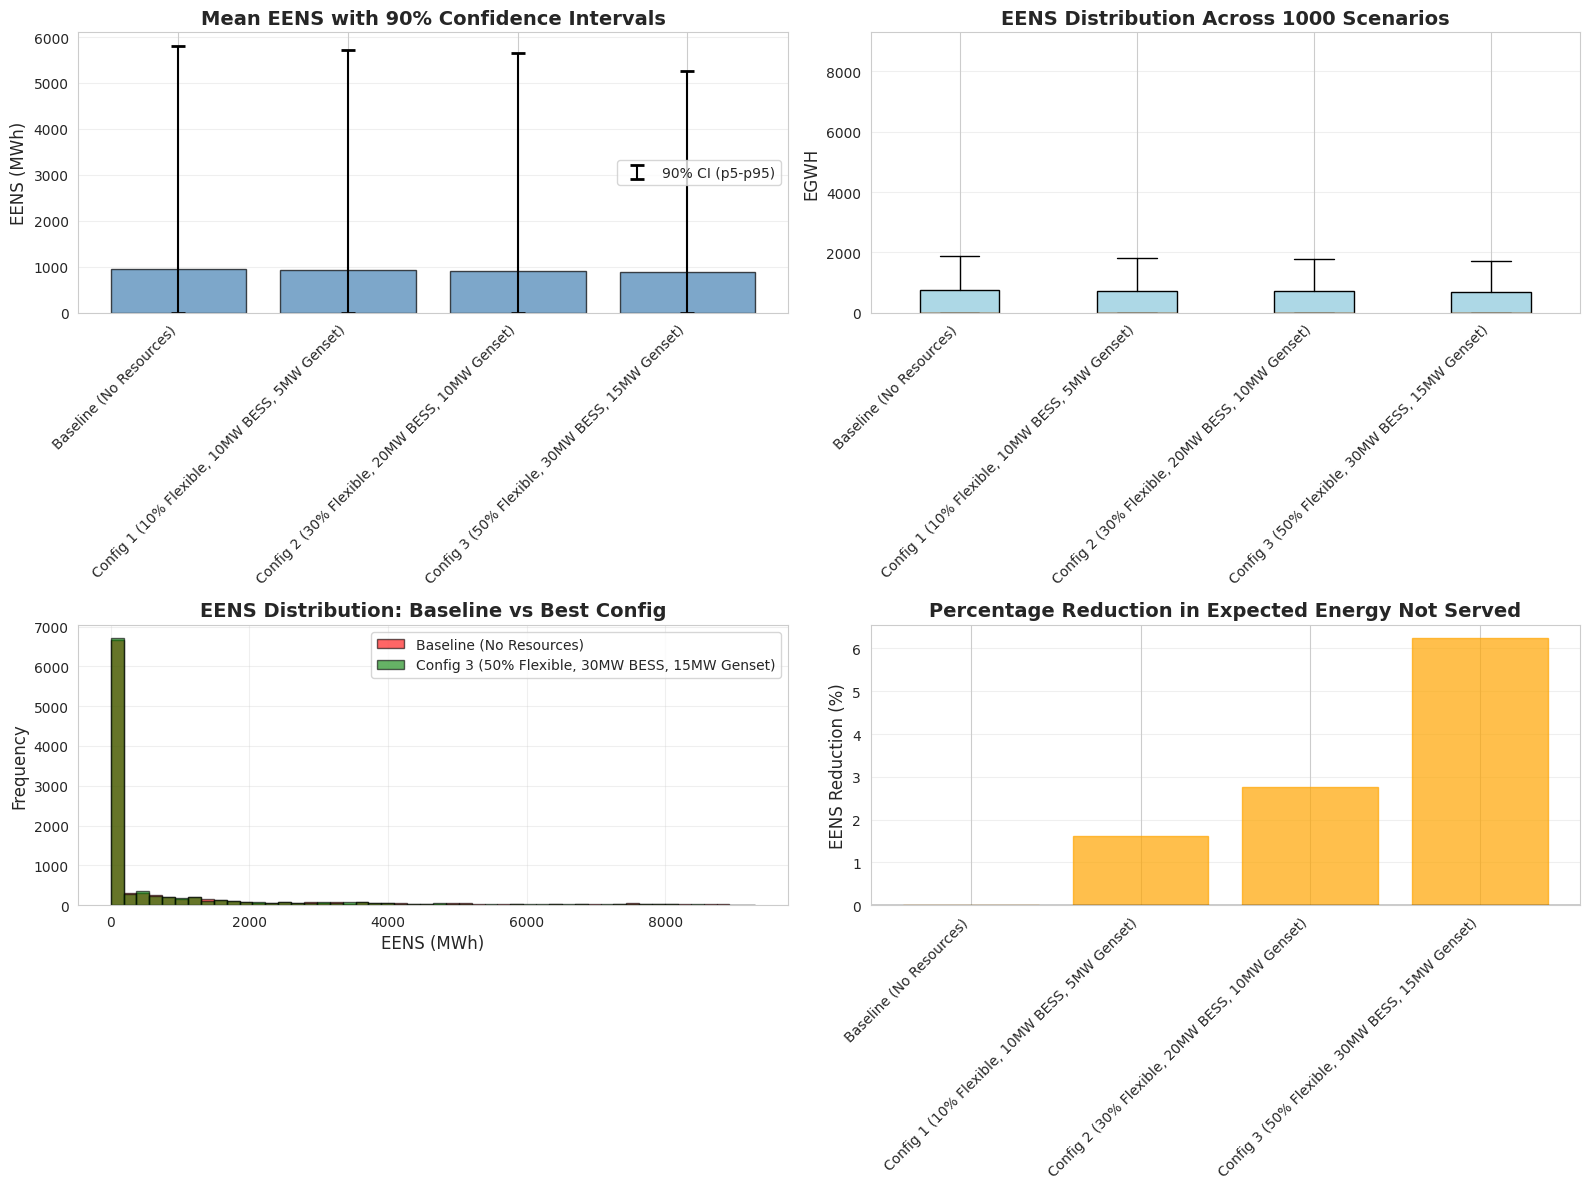

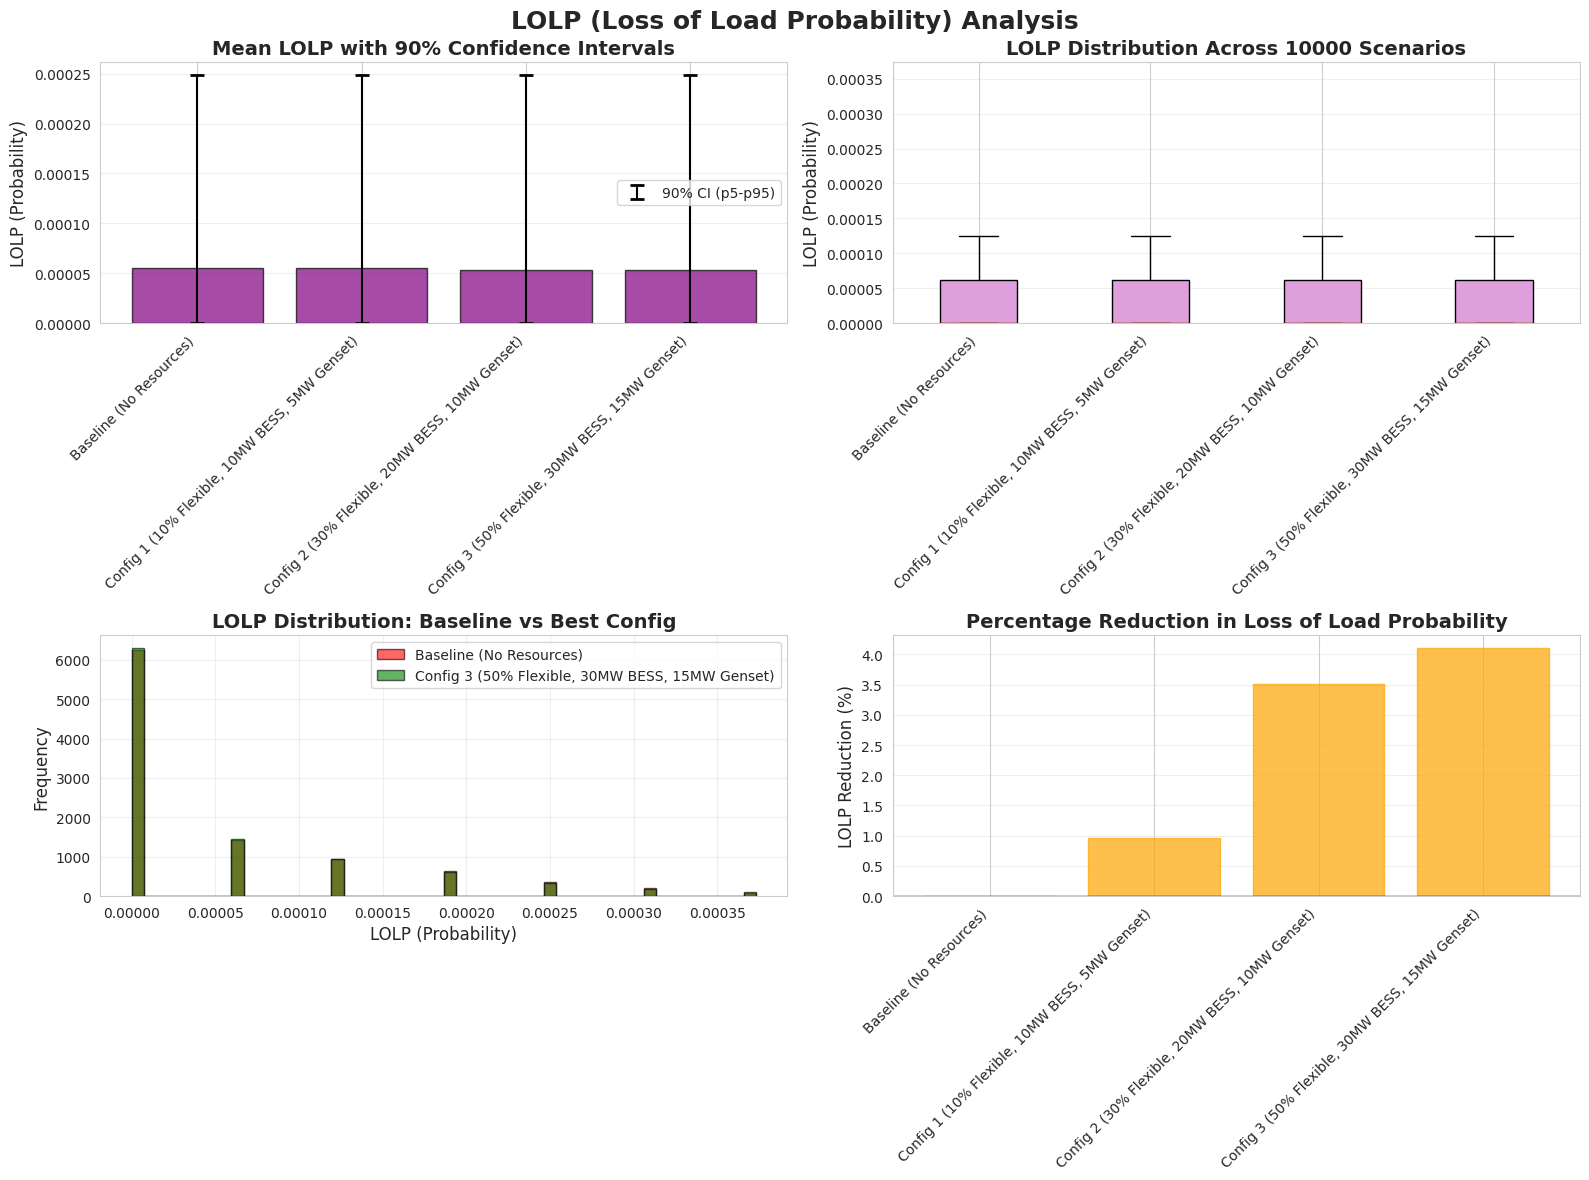

In [ ]:
print("="*80)
print("11. MONTE CARLO RELIABILITY ANALYSIS - BLOCK BOOTSTRAP")
print("="*80)

# MODEL SELECTION: Use Fold 5 for operational realism
print("\n" + "="*80)
print("MODEL SELECTION FOR RELIABILITY ANALYSIS")
print("="*80)
print(f"Best performing fold: Fold 3 (R² = 0.9492, MAPE = 3.57%)")
print(f"Selected for analysis: Fold 5 (R² = 0.8855, MAPE = 6.03%)")
print(f"\nRationale:")
print(f"  - Fold 5 represents most recent data (operational realism)")
print(f"  - Tests model's ability to forecast beyond training distribution")
print(f"  - Industry standard: always test on forward-looking holdout")
print(f"  - More conservative, defensible reliability estimates")
print("="*80)


# Get the latest data (fold 5)
operational_fold_idx = 4 # Index 4 is the 5th fold

# Get Fold 5 model
if 'hybrid_fold_models' not in locals():
    raise NameError("Must run training section first. hybrid_fold_models not found.")

model_to_test = hybrid_fold_models[operational_fold_idx]  # Use Fold 5 model
print(f"\nUsing Fold 5 model for simulation (trained on first 80,355 hours)")

# Get the test set data from Fold 5
print(f"\nGenerating test set from Fold 5...")
try:
    _, test_indices = list(tscv.split(X_full))[operational_fold_idx]
    X_fold_test = X_full.iloc[test_indices]
    y_fold_test = y_full.iloc[test_indices]
    print(f"Using test set with {len(y_fold_test)} samples from Fold 5.")
except NameError:
     raise NameError("CV variables ('tscv', 'X_full') not found. Run Section 4 first.")

# Generate the model's forecast (THE SIGNAL)
print("\nGenerating forecast from Fold 5 model (This is our 'Signal')...")
train_indices, _ = list(tscv.split(X_full))[operational_fold_idx]
start_index_for_test = len(train_indices)
y_forecast_signal = model_to_test.predict(X_fold_test, start_idx=start_index_for_test)
print(f"Forecast 'Signal' generated: {len(y_forecast_signal)} hours")


# Calculate residuals from TEST SET ONLY (THE NOISE)
print("\n" + "="*80)
print("BLOCK BOOTSTRAP 'NOISE' SETUP")
print("="*80)

# IMPORTANT: Ensure y_forecast and y_fold_test have the same length
if len(y_forecast_signal) > len(y_fold_test):
    print(f"WARNING: Forecast longer than test set. Trimming forecast from {len(y_forecast_signal)} to {len(y_fold_test)} samples.")
    y_forecast_signal = y_forecast_signal[:len(y_fold_test)]
elif len(y_forecast_signal) < len(y_fold_test):
    print(f"WARNING: Forecast shorter than test set. Padding forecast from {len(y_forecast_signal)} to {len(y_fold_test)} samples.")
    padding = np.mean(y_forecast_signal) * np.ones(len(y_fold_test) - len(y_forecast_signal))
    y_forecast_signal = np.concatenate([y_forecast_signal, padding])

print(f"Aligned lengths - Signal: {len(y_forecast_signal)}, Actuals: {len(y_fold_test)}")

# This is the "Noise Library" which measures how much noise would be introduced into the model. The error is inherently noisy, so we want to debias the model to prevent it from overstating the facts.
# Running without debiasing is the equivilent of saying every day is a black swan (~3000 MW event with a standard deviation of 2249, so it is not uncommon to see an event that causes a disruption over 5000 MW)
# How much could a DC loaded at 25 MW provide when the disruptions are of that magnitute?

residuals_library = y_fold_test.values - y_forecast_signal
residuals_library = residuals_library - np.mean(residuals_library) # debias the model

print(f"\nResidual 'Noise Library' Statistics:")
print(f"  Mean: {np.mean(residuals_library):.2f} MW")
print(f"  Std:  {np.std(residuals_library):.2f} MW")

# ============================================================================
# CONFIGURE DATA CENTER SCENARIOS
# ============================================================================

print("\n" + "="*80)
print("DATA CENTER CONFIGURATIONS")
print("="*80)

configs = [
    DataCenterResources(
        it_load_mw=25, flexible_it_pct=0.0,
        bess_power_mw=0, bess_energy_mwh=0, genset_capacity_mw=0,
        ffr_response_time_s=0.3, bess_soc_initial_pct=0.5),
    DataCenterResources(
        it_load_mw=25, flexible_it_pct=0.1,
        bess_power_mw=10, bess_energy_mwh=40, genset_capacity_mw=5,
        ffr_response_time_s=0.3, bess_soc_initial_pct=0.5),
    DataCenterResources(
        it_load_mw=25, flexible_it_pct=0.3,
        bess_power_mw=20, bess_energy_mwh=80, genset_capacity_mw=10,
        ffr_response_time_s=0.3, bess_soc_initial_pct=0.5),
    DataCenterResources(
        it_load_mw=25, flexible_it_pct=0.5,
        bess_power_mw=30, bess_energy_mwh=120, genset_capacity_mw=15,
        ffr_response_time_s=0.3, bess_soc_initial_pct=0.5)
]
config_names = [
    "Baseline (No Resources)",
    "Config 1 (10% Flexible, 10MW BESS, 5MW Genset)",
    "Config 2 (30% Flexible, 20MW BESS, 10MW Genset)",
    "Config 3 (50% Flexible, 30MW BESS, 15MW Genset)"
]
print(f"\nDefined {len(configs)} configurations for testing")

# ============================================================================
# RUN BOOTSTRAP MONTE CARLO
# ============================================================================

print("\n" + "="*80)
print("BOOTSTRAP MONTE CARLO SIMULATION")
print("="*80)

# Define n_scenarios
n_scenarios = 10000 # You can set this to 10 for a test, or 1000 for production
block_size = 24 # 24-hour block size to preserve daily patterns

print(f"Running {n_scenarios} bootstrap scenarios with a {block_size}-hour block size...")

# This one function call runs the entire simulation
# It uses the functions we defined in the cell above (Cell 10.5)
comparison_df_mc = run_bootstrap_analysis(
    dc_configs=configs,
    config_names=config_names,
    y_signal_future=y_forecast_signal,
    all_errors_library=residuals_library,
    n_scenarios=n_scenarios,
    block_size=block_size,
    random_seed=42
)

print("\n✓ Bootstrap simulation complete!")

# ============================================================================
# AGGREGATE RESULTS & CREATE COMPARISON DATAFRAME
# ============================================================================

print("\n" + "="*80)
print("AGGREGATING RESULTS")
print("="*80)

# 1. Capture Baseline Data First (Assumes first row is Baseline)
baseline_row = comparison_df_mc.iloc[0]
base_eens_scenarios = baseline_row['eens_all_scenarios']
base_lolp_scenarios = baseline_row['lolp_all_scenarios']
base_eens_mean = baseline_row['eens_with_dc_mean']
base_lolp_mean = baseline_row['lolp_with_dc_mean']

results_summary = []
all_lolp_data = {}
all_eens_data = {}

for _, row in comparison_df_mc.iterrows():
    name = row['configuration']

    # Store data for plots
    eens_scenarios = row['eens_all_scenarios']
    lolp_scenarios = row['lolp_all_scenarios']
    all_eens_data[name] = eens_scenarios
    all_lolp_data[name] = lolp_scenarios

    n_samples = len(eens_scenarios)

    # --- CALCULATION 1: Absolute CI (Standard Error / Z-Interval) ---
    # Formula: 1.96 * (std / sqrt(N))

    # EENS Absolute
    eens_std = np.std(eens_scenarios)
    eens_abs_ci = 1.96 * (eens_std / np.sqrt(n_samples))

    # LOLP Absolute
    lolp_std = np.std(lolp_scenarios)
    lolp_abs_ci = 1.96 * (lolp_std / np.sqrt(n_samples))

    # --- CALCULATION 2: Percent Reduction CI ---
    # We calculate the CI of the *difference* and convert to %

    # EENS Reduction
    eens_diff_scenarios = base_eens_scenarios - eens_scenarios
    eens_diff_std = np.std(eens_diff_scenarios)
    eens_diff_ci_abs = 1.96 * (eens_diff_std / np.sqrt(n_samples))
    if base_eens_mean > 0:
        eens_red_ci_pct = (eens_diff_ci_abs / base_eens_mean) * 100
    else:
        eens_red_ci_pct = 0.0

    # LOLP Reduction
    lolp_diff_scenarios = base_lolp_scenarios - lolp_scenarios
    lolp_diff_std = np.std(lolp_diff_scenarios)
    lolp_diff_ci_abs = 1.96 * (lolp_diff_std / np.sqrt(n_samples))
    if base_lolp_mean > 0:
        lolp_red_ci_pct = (lolp_diff_ci_abs / base_lolp_mean) * 100
    else:
        lolp_red_ci_pct = 0.0

    results_summary.append({
        'configuration': name,

        # --- REPORT COLUMNS (Formatted Strings) ---

        # Absolute Reports (e.g., "940.01 ± 40.45")
        'EENS (MWh)': f"{row['eens_with_dc_mean']:.2f} ± {eens_abs_ci:.2f}",
        'LOLP (Prob)': f"{row['lolp_with_dc_mean']:.4f} ± {lolp_abs_ci:.4f}",

        # Reduction Reports (e.g., "6.24% ± 0.15%")
        'EENS Reduction (%)': f"{row['eens_pct_reduction']:.2f}% ± {eens_red_ci_pct:.2f}%",
        'LOLP Reduction (%)': f"{row['lolp_pct_reduction']:.2f}% ± {lolp_red_ci_pct:.2f}%",

        # --- RAW NUMERICS (For Plotting) ---
        'eens_mean': row['eens_with_dc_mean'],
        'eens_pct_reduction': row['eens_pct_reduction'],
        'lolp_mean': row['lolp_with_dc_mean'],
        'lolp_pct_reduction': row['lolp_pct_reduction'],
        'eens_p5': np.percentile(eens_scenarios, 5),
        'eens_p95': np.percentile(eens_scenarios, 95),
        'lolp_p5': np.percentile(lolp_scenarios, 5),
        'lolp_p95': np.percentile(lolp_scenarios, 95),
    })

agg_results_df = pd.DataFrame(results_summary)

print("\nAggregated Results DataFrame (Combined Report):")
# Define the order of columns for the final report
report_cols = [
    'configuration',
    'EENS (MWh)',
    'EENS Reduction (%)',
    'LOLP (Prob)',
    'LOLP Reduction (%)'
]
print(agg_results_df[report_cols].to_string(index=False))

# --- Result visualizations ---

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Mean EENS with error bars
ax = axes[0, 0]
x_pos = np.arange(len(config_names))
means = agg_results_df['eens_mean'].values
p5 = agg_results_df['eens_p5'].values
p95 = agg_results_df['eens_p95'].values

ax.bar(x_pos, means, alpha=0.7, color='steelblue', edgecolor='black')
ax.errorbar(x_pos, means, yerr=[means - p5, p95 - means],
            fmt='none', color='black', capsize=5, capthick=2,
            label='90% CI (p5-p95)')
ax.set_xticks(x_pos)
ax.set_xticklabels(config_names, rotation=45, ha='right')
ax.set_ylabel('EENS (MWh)', fontsize=12)
ax.set_title('Mean EENS with 90% Confidence Intervals', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Plot 2: Distribution (boxplot)
ax = axes[0, 1]
data_to_plot = [all_eens_data[name] for name in config_names]
bp = ax.boxplot(data_to_plot, labels=config_names, patch_artist=True, showfliers=False) # showfliers=False to hide outliers
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
    patch.set_edgecolor('black')
ax.set_xticklabels(config_names, rotation=45, ha='right')
ax.set_ylabel('EGWH', fontsize=12)
ax.set_title('EENS Distribution Across 1000 Scenarios', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(bottom=0, top=np.percentile(all_eens_data[config_names[0]], 99)) # Zoom in

# Plot 3: Histogram comparison
ax = axes[1, 0]
baseline_data = all_eens_data[config_names[0]]
best_data = all_eens_data[config_names[-1]]
ax.hist(baseline_data, bins=50, alpha=0.6, label=config_names[0], color='red', edgecolor='black', range=(0, np.percentile(baseline_data, 99)))
ax.hist(best_data, bins=50, alpha=0.6, label=config_names[-1], color='green', edgecolor='black', range=(0, np.percentile(baseline_data, 99)))
ax.set_xlabel('EENS (MWh)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('EENS Distribution: Baseline vs Best Config', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Percent reduction
ax = axes[1, 1]
reductions = agg_results_df['eens_pct_reduction'].values
bars = ax.bar(x_pos, reductions, alpha=0.7, edgecolor='black')
for i, bar in enumerate(bars):
    if reductions[i] > 90:
        bar.set_color('darkgreen')
    elif reductions[i] > 50:
        bar.set_color('green')
    else:
        bar.set_color('orange')
ax.set_xticks(x_pos)
ax.set_xticklabels(config_names, rotation=45, ha='right')
ax.set_ylabel('EENS Reduction (%)', fontsize=12)
ax.set_title('Percentage Reduction in Expected Energy Not Served', fontsize=14, fontweight='bold')
ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('bootstrap_results_final.png', dpi=300, bbox_inches='tight')
plt.show()

fig_lolp, axes_lolp = plt.subplots(2, 2, figsize=(16, 12))
fig_lolp.suptitle('LOLP (Loss of Load Probability) Analysis', fontsize=18, fontweight='bold')

# Plot 1: Mean LOLP with error bars
ax = axes_lolp[0, 0]
x_pos = np.arange(len(config_names))
means_lolp = agg_results_df['lolp_mean'].values
p5_lolp = agg_results_df['lolp_p5'].values
p95_lolp = agg_results_df['lolp_p95'].values

ax.bar(x_pos, means_lolp, alpha=0.7, color='purple', edgecolor='black')
ax.errorbar(x_pos, means_lolp, yerr=[means_lolp - p5_lolp, p95_lolp - means_lolp],
            fmt='none', color='black', capsize=5, capthick=2,
            label='90% CI (p5-p95)')
ax.set_xticks(x_pos)
ax.set_xticklabels(config_names, rotation=45, ha='right')
ax.set_ylabel('LOLP (Probability)', fontsize=12)
ax.set_title('Mean LOLP with 90% Confidence Intervals', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Plot 2: LOLP Distribution (boxplot)
ax = axes_lolp[0, 1]
data_to_plot_lolp = [all_lolp_data[name] for name in config_names]
bp_lolp = ax.boxplot(data_to_plot_lolp, tick_labels=config_names, patch_artist=True, showfliers=False) # Use tick_labels
for patch in bp_lolp['boxes']:
    patch.set_facecolor('plum')
    patch.set_edgecolor('black')
ax.set_xticklabels(config_names, rotation=45, ha='right')
ax.set_ylabel('LOLP (Probability)', fontsize=12)
ax.set_title('LOLP Distribution Across 10000 Scenarios', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
# Adjust ylim for LOLP data
ax.set_ylim(bottom=0, top=np.percentile(all_lolp_data[config_names[0]], 99)) # Zoom in

# Plot 3: LOLP Histogram comparison
ax = axes_lolp[1, 0]
baseline_data_lolp = all_lolp_data[config_names[0]]
best_data_lolp = all_lolp_data[config_names[-1]]
hist_range_lolp = (0, np.percentile(baseline_data_lolp, 99))
ax.hist(baseline_data_lolp, bins=50, alpha=0.6, label=config_names[0], color='red', edgecolor='black', range=hist_range_lolp)
ax.hist(best_data_lolp, bins=50, alpha=0.6, label=config_names[-1], color='green', edgecolor='black', range=hist_range_lolp)
ax.set_xlabel('LOLP (Probability)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('LOLP Distribution: Baseline vs Best Config', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: LOLP Percent reduction
ax = axes_lolp[1, 1]
reductions_lolp = agg_results_df['lolp_pct_reduction'].values
bars_lolp = ax.bar(x_pos, reductions_lolp, alpha=0.7, edgecolor='black')
for i, bar in enumerate(bars_lolp):
    if reductions_lolp[i] > 90:
        bar.set_color('darkgreen')
    elif reductions_lolp[i] > 50:
        bar.set_color('green')
    else:
        bar.set_color('orange')
ax.set_xticks(x_pos)
ax.set_xticklabels(config_names, rotation=45, ha='right')
ax.set_ylabel('LOLP Reduction (%)', fontsize=12)
ax.set_title('Percentage Reduction in Loss of Load Probability', fontsize=14, fontweight='bold')
ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('lolp_bootstrap_results_final.png', dpi=300, bbox_inches='tight')
plt.show()

## 12. Model Coefficients

In [ ]:
# --- Get Model Coefficients & Importances for Appendix (Final Version v2) ---
# (Run this cell *after* Cell 11)

import pandas as pd
import numpy as np

print("="*80)
print("HYBRID MODEL INTERNALS (from Fold 5 Model)")
print("="*80)

# 1. Get Trend Model Coefficients (Linear Regression)
# ---------------------------------------------------
# This part is working correctly.
try:
    slope = model_to_test.trend_slope
    intercept = model_to_test.trend_intercept

    if isinstance(slope, (np.ndarray, list)):
         slope_val = slope[0]
    else:
         slope_val = slope

    print("\n--- 1. Trend Model (Linear Regression) ---")
    print(f"Trend Coefficient (Slope 'm'): {slope_val:.4f}")
    print(f"Trend Intercept ('b'):     {intercept:.4f}")
    print("\n(This means the trend increases by ~{:.2f} MW per hour on average)".format(slope_val))

except Exception as e:
    print(f"An error occurred accessing trend model: {e}")


# 2. Get Seasonal Model Feature Importances (XGBoost)
# ----------------------------------------------------
# CORRECTED: The native 'Booster' object ('xgb_model')
# uses .get_score() not .feature_importances_

try:
    seasonal_model = model_to_test.xgb_model
    feature_names = model_to_test.feature_names

    # Use .get_score() to get importances as a dictionary
    importance_dict = seasonal_model.get_score(importance_type='weight')

    # Convert the dictionary to a clean DataFrame
    importance_df = pd.DataFrame({
        'Feature': importance_dict.keys(),
        'Importance': importance_dict.values()
    }).sort_values(by='Importance', ascending=False)

    print("\n\n--- 2. Seasonal Model (XGBoost Importances) ---")
    print(importance_df.to_string(index=False))

except NameError:
    print("Error: 'model_to_test' not found. Please run the model selection in Cell 11 first.")
except Exception as e:
    print(f"An error occurred accessing seasonal model: {e}")

print("\n" + "="*80)

HYBRID MODEL INTERNALS (from Fold 5 Model)

--- 1. Trend Model (Linear Regression) ---
Trend Coefficient (Slope 'm'): 0.1024
Trend Intercept ('b'):     38154.6025

(This means the trend increases by ~0.10 MW per hour on average)


--- 2. Seasonal Model (XGBoost Importances) ---
               Feature  Importance
           day_of_year      2265.0
                  hour      1969.0
                  year      1449.0
         weighted_temp      1381.0
weighted_apparent_temp      1134.0
    weighted_dew_point       903.0
           day_of_week       824.0
  weighted_cloud_cover       729.0
     weighted_humidity       582.0
   weighted_wind_speed       572.0
   weighted_wind_gusts       505.0
weighted_precipitation       343.0
                 month       292.0



##13 Save Results

In [ ]:
from availability_model.config import RESULTS_DIR, MODELS_DIR
import os

print("="*80)
print("SAVING ALL RESULTS")
print("="*80)

# Save results dataframes
stl_results_df.to_csv(str(RESULTS_DIR / 'stl_xgboost_timeseries_cv_results.csv'), index=False)
hybrid_results_df.to_csv(str(RESULTS_DIR / 'hybrid_timeseries_cv_results.csv'), index=False)
comparison_df.to_csv(str(RESULTS_DIR / 'model_comparison_summary.csv'), index=False)
comparison_table.to_csv(str(RESULTS_DIR / 'forecast_comparison_table.csv'), index=False)
comparison_df_mc.to_csv(str(RESULTS_DIR / 'monte_carlo_reliability_results.csv'), index=False)

print(f"\n✓ Results saved:")
print(f"  - stl_xgboost_timeseries_cv_results.csv")
print(f"  - hybrid_timeseries_cv_results.csv")
print(f"  - model_comparison_summary.csv")
print(f"  - forecast_comparison_table.csv")
print(f"  - monte_carlo_reliability_results.csv")

# Save best models
best_forecaster.save_model(str(MODELS_DIR / "best_stl_xgboost_model.pkl"))
best_hybrid_forecaster.save_model(str(MODELS_DIR / "best_hybrid_model.pkl"))

print(f"\n✓ Models saved:")
print(f"  - best_stl_xgboost_model.pkl")
print(f"  - best_hybrid_model.pkl")

print(f"\n" + "="*80)
print(f"✅ FULL TRAINING PIPELINE COMPLETE")
print(f"="*80)
print(f"\nResults location: {RESULTS_DIR}")
print(f"Models location: {MODELS_DIR}")

SAVING ALL RESULTS

✓ Results saved:
  - stl_xgboost_timeseries_cv_results.csv
  - hybrid_timeseries_cv_results.csv
  - model_comparison_summary.csv
  - forecast_comparison_table.csv
  - monte_carlo_reliability_results.csv

✓ Models saved:
  - best_stl_xgboost_model.pkl
  - best_hybrid_model.pkl

✅ FULL TRAINING PIPELINE COMPLETE

Results location: /content/Capstone_Availability_Model/results
Models location: /content/Capstone_Availability_Model/models
